<a href="https://colab.research.google.com/github/sanjuktaroy/BrainTumorClassification/blob/main/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


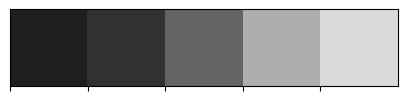

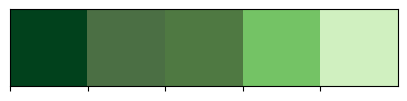

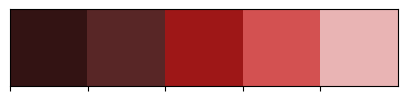

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [5]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Dataset for Brain Classification/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Dataset for Brain Classification/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 30/30 [00:10<00:00,  2.85it/s]


In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(270, 150, 150, 3)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [11]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [15]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.963055 to fit



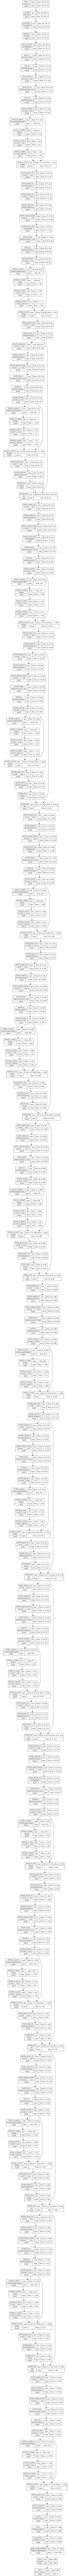

In [16]:
model_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file,
                          show_shapes=True,
                          show_layer_activations=True,
                          show_dtype=True,
                          show_layer_names=True )

In [20]:
# training the model
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
7/7 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9954
Epoch 1: val_accuracy did not improve from 0.80000
7/7 [==============================] - 27s 4s/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.9959 - val_accuracy: 0.8000 - lr: 9.0000e-05
Epoch 2/12
7/7 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9954
Epoch 2: val_accuracy did not improve from 0.80000
7/7 [==============================] - 27s 4s/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.9658 - val_accuracy: 0.8000 - lr: 9.0000e-05
Epoch 3/12
7/7 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.80000

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
7/7 [==============================] - 27s 4s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.9436 - val_accuracy: 0.8000 - lr: 9.0000e-05
Epoch 4/12
7/7 [==============================] - ETA: 0s - lo

In [21]:
# predicting
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

1/1 [==============================] - 2s 2s/step


In [22]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.57      0.80      0.67         5
           2       0.75      1.00      0.86         6
           3       1.00      1.00      1.00         7

    accuracy                           0.78        27
   macro avg       0.78      0.81      0.77        27
weighted avg       0.80      0.78      0.76        27



In [23]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [24]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [25]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])